# Import libraries


In [10]:
import mpctools as mpc
import casadi
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import linalg
from numpy import random

# NMHE simulations


In [11]:
def run_nmhe_simulation(x0, Nsim=80, fullInformation=False):
    
    # Problem parameters.
    Nt = 10            # Horizon length.
    Delta = 0.25       # Time step.
    Nx = 3
    Nu = 1
    Ny = 1
    Nw = Nx
    Nv = Ny

    sigma_v = 0.25   # Measurement noise std.
    sigma_w = 0.001  # Process noise std.
    sigma_p = 0.5    # Prior std.

    # Covariance matrices.
    P = np.diag((sigma_p*np.ones((Nx,)))**2)
    Q = np.diag((sigma_w*np.ones((Nw,)))**2)
    R = np.diag((sigma_v*np.ones((Nv,)))**2)
    x_0 = np.array([1.0, 0.0, 4.0])
    
    # System parameters.
    k1 = 0.5
    k_1 = 0.05
    k2 = 0.2
    k_2 = 0.01
    RT = 32.84

    # Define the continuous-time ODE.
    def ode(x, u, w=[0,0,0]):
        [cA, cB, cC] = x[:]
        rate1 = k1*cA - k_1*cB*cC    
        rate2 = k2*cB**2 - k_2*cC
        dxdt = [
            -rate1 + w[0],
            rate1 - 2*rate2 + w[1],
            rate1 + rate2 + w[2],
        ]
        return np.array(dxdt)
    
    # Measurement function.
    def measurement(x):
        return RT * (x[0] + x[1] + x[2])
    
    # Get CasADi functions.
    ode_casadi = mpc.getCasadiFunc(ode, [Nx, Nu, Nw], ["x", "u", "w"], "F")
    model = mpc.DiscreteSimulator(ode, Delta, [Nx, Nu, Nw], ["x", "u", "w"])
    F = mpc.getCasadiFunc(ode, [Nx, Nu, Nw], ["x", "u", "w"], "F",
                          rk4=True, Delta=Delta, M=2)
    H = mpc.getCasadiFunc(measurement, [Nx], ["x"], "H")
    
    # Stage cost functions.
    def lfunc(w, v):
        return sigma_w**-2 * mpc.mtimes(w.T, w) + sigma_v**-2 * mpc.mtimes(v.T, v)
    l = mpc.getCasadiFunc(lfunc, [Nw, Nv], ["w", "v"], "l")
    
    def lxfunc(x, x0bar, Pinv):
        dx = x - x0bar
        return mpc.mtimes(dx.T, Pinv, dx)
    lx = mpc.getCasadiFunc(lxfunc, [Nx, Nx, (Nx, Nx)], ["x", "x0bar", "Pinv"], "lx")
    
    # First simulate the process.
    w = sigma_w * random.randn(Nsim, Nw)
    v = sigma_v * random.randn(Nsim, Nv)
    usim = np.zeros((Nsim, Nu))  # Dummy input.
    xsim = np.zeros((Nsim+1, Nx))
    xsim[0, :] = x0
    yclean = np.zeros((Nsim, Ny))
    ysim = np.zeros((Nsim, Ny))
    for t in range(Nsim):
        yclean[t, :] = measurement(xsim[t])
        ysim[t, :] = yclean[t, :] + v[t, :]
        xsim[t+1, :] = model.sim(xsim[t, :], usim[t, :], w[t, :])
    
    # Now do MHE estimation.
    xhat_ = np.zeros((Nsim+1, Nx))
    xhat = np.zeros((Nsim, Nx))
    yhat = np.zeros((Nsim, Ny))
    vhat = np.zeros((Nsim, Nv))
    what = np.zeros((Nsim, Nw))
    x0bar = x_0
    xhat[0, :] = x0bar
    guess = {}
    
    for t in range(Nsim):
        N = {"x": Nx, "y": Ny, "u": Nu}
        if fullInformation:
            N["t"] = t
            tmin = 0
        else:
            N["t"] = min(t, Nt)
            tmin = max(0, t - Nt)
        tmax = t + 1        
        lb = {"x": np.zeros((N["t"] + 1, Nx))}
    
        if fullInformation or t < Nt:
            solver = mpc.nmhe(f=F, h=H, u=usim[tmin:tmax-1, :],
                              y=ysim[tmin:tmax, :], l=l, N=N, lx=lx,
                              x0bar=x0bar, verbosity=0, guess=guess,
                              lb=lb, extrapar=dict(Pinv=linalg.inv(P)),
                              inferargs=True)
        else:
            solver.par["Pinv"] = linalg.inv(P)
            solver.par["x0bar"] = x0bar
            solver.par["y"] = list(ysim[tmin:tmax, :])
            solver.par["u"] = list(usim[tmin:tmax - 1, :])
    
        sol = mpc.callSolver(solver)
        if sol["status"] != "Solve_Succeeded":
            break
        xhat[t, :] = sol["x"][-1, ...]
        yhat[t, :] = measurement(xhat[t, :])
        vhat[t, :] = sol["v"][-1, ...]
        if t > 0:
            what[t-1, :] = sol["w"][-1, ...]
        xhat_[t+1, :] = np.squeeze(F(xhat[t, :], usim[t, :], np.zeros((Nw,))))
        guess = {}
        for k in set(["x", "w", "v"]).intersection(sol.keys()):
            guess[k] = sol[k].copy()
        if (not fullInformation) and (t + 1 > Nt):
            for k in guess.keys():
                guess[k] = guess[k][1:,...]
            [P, x0bar, _, _] = mpc.ekf(F, H, x=sol["x"][0, ...],
                                        u=usim[tmin, :], w=sol["w"][0, ...],
                                        y=ysim[tmin, :], P=P, Q=Q, R=R)
        for k in guess.keys():
            guess[k] = np.concatenate((guess[k], guess[k][-1:,...]))
    
    return ysim, xhat, xsim


## Generate dataset

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def generate_dataset(num_trajectories=100, Nsim=80, horizon=10):
    X_list = []
    Y_list = []
    for traj in range(num_trajectories):
        # Random initial condition.
        x0 = np.random.uniform(low=0.0, high=5.0, size=(3,))
        ysim, xhat, _ = run_nmhe_simulation(x0, Nsim=Nsim, fullInformation=False)
        for t in range(horizon, Nsim):
            s = ysim[t - horizon : t + 1].flatten() 
            X_list.append(s)
            Y_list.append(xhat[t])
    X_array = np.array(X_list)
    Y_array = np.array(Y_list)
    return X_array, Y_array

# Generate training data.
num_trajectories = 100
Nsim = 80        # Simulation length.
horizon = 10     # Measurement history length.
X_data, Y_data = generate_dataset(num_trajectories=num_trajectories, Nsim=Nsim, horizon=horizon)

# Prepare PyTorch dataset and dataloader.
X_tensor = torch.tensor(X_data, dtype=torch.float32)
Y_tensor = torch.tensor(Y_data, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## Training

In [13]:
class EstimatorNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[50,50,50,50,50,50]):
        super(EstimatorNN, self).__init__()
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

input_dim = X_data.shape[1]  # (horizon+1)*Ny.
output_dim = Y_data.shape[1] # Nx = 3.
net = EstimatorNN(input_dim, output_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-6)
num_epochs = 200

print("Starting NN training...")
for epoch in range(num_epochs):
    for batch_X, batch_Y in dataloader:
        optimizer.zero_grad()
        outputs = net(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")
torch.save(net.state_dict(), "mhe_estimator.pth")
print("NN training complete and model saved.")

Starting NN training...
Epoch 10/200, Loss: 16.500494
Epoch 20/200, Loss: 8.222604
Epoch 30/200, Loss: 4.689775
Epoch 40/200, Loss: 0.478606
Epoch 50/200, Loss: 0.084549
Epoch 60/200, Loss: 0.076228
Epoch 70/200, Loss: 0.039278
Epoch 80/200, Loss: 0.050024
Epoch 90/200, Loss: 0.092178
Epoch 100/200, Loss: 0.158072
Epoch 110/200, Loss: 0.097388
Epoch 120/200, Loss: 0.125844
Epoch 130/200, Loss: 0.100554
Epoch 140/200, Loss: 0.107538
Epoch 150/200, Loss: 0.058169
Epoch 160/200, Loss: 0.172559
Epoch 170/200, Loss: 0.076095
Epoch 180/200, Loss: 0.080500
Epoch 190/200, Loss: 0.045825
Epoch 200/200, Loss: 0.030978
NN training complete and model saved.


## Compare NN estimator with MHE

/var/folders/h2/8pdch8s51cq1775ccq_515c80000gn/T/ipykernel_26558/1281177894.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("mhe_estimator

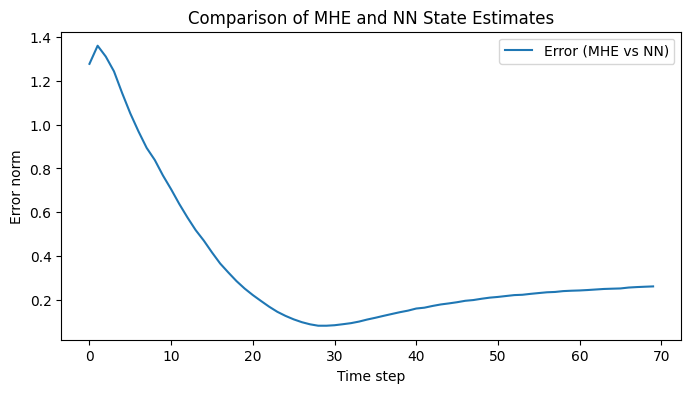

Average NN inference time: 0.0000 s


Exception: CasADi matrices are not iterable by design.
                      Did you mean to iterate over m.nz, with m IM/DM/SX?
                      Did you mean to iterate over horzsplit(m,1)/vertsplit(m,1) with m IM/DM/SX/MX?
                      

In [ ]:
# Run a test simulation with an unseen initial condition.
x0_test = np.random.uniform(low=0.0, high=5.0, size=(3,))
ysim_test, xhat_mhe, _ = run_nmhe_simulation(x0_test, Nsim=Nsim, fullInformation=False)

# Load the trained NN model.
net.load_state_dict(torch.load("mhe_estimator.pth"))
net.eval()

xhat_nn = []
nn_times = []
for t in range(horizon, Nsim):
    s = ysim_test[t - horizon : t + 1].flatten()
    s_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    start_time = time.time()
    x_nn = net(s_tensor).detach().numpy().flatten()
    nn_times.append(time.time() - start_time)
    xhat_nn.append(x_nn)
xhat_nn = np.array(xhat_nn)

# Compare estimates: if available, you can compare against true states (xsim),
# but here we compare the NN estimates with the MHE estimates.
errors = np.linalg.norm(xhat_mhe[horizon:] - xhat_nn, axis=1)
plt.figure(figsize=(8, 4))
plt.plot(errors, label="Error (MHE vs NN)")
plt.xlabel("Time step")
plt.ylabel("Error norm")
plt.title("Comparison of MHE and NN State Estimates")
plt.legend()
plt.show()

print("Average NN inference time: {:.4f} s".format(np.mean(nn_times)))

Nx = 3
Nu = 1
Nw = Nx

# Define symbolic variables.
import casadi as ca
x_sym = ca.SX.sym("x", Nx)
u_sym = ca.SX.sym("u", Nu)
d_sym = ca.SX.sym("d", Nw)

# System parameters (same as simulation).
k1 = 0.5
k_1 = 0.05
k2 = 0.2
k_2 = 0.01
RT = 32.84

def ode_sym(x, u, d):
    import casadi as ca
    [cA, cB, cC] = x
    rate1 = k1*cA - k_1*cB*cC    
    rate2 = k2*cB**2 - k_2*cC
    dxdt = [ -rate1 + d[0],
             rate1 - 2*rate2 + d[1],
             rate1 + rate2 + d[2] ]
    return ca.vertcat(*dxdt)

f_sym = ode_sym(x_sym, u_sym, d_sym)

# Compute the Jacobians.
J_u_sym = ca.jacobian(f_sym, u_sym)
J_x_sym = ca.jacobian(f_sym, x_sym)

J_u_func = ca.Function("J_u", [x_sym, u_sym, d_sym], [J_u_sym])
J_x_func = ca.Function("J_x", [x_sym, u_sym, d_sym], [J_x_sym])

# Evaluate at a chosen operating point.
x_k = xhat_mhe[horizon]   # Operating point from MHE.
u_k = np.array([0.0])     # Assume zero control input.
d_k = np.zeros(Nw)        # Assume zero disturbance.

J_u_val = np.array(J_u_func(x_k, u_k, d_k))
J_x_val = np.array(J_x_func(x_k, u_k, d_k))

# Compute the maximum singular value.
sigma_max_u = np.linalg.svd(J_u_val, compute_uv=False)[0]
sigma_max_x = np.linalg.svd(J_x_val, compute_uv=False)[0]

print("sigma_max(J_u):", sigma_max_u)
print("sigma_max(J_x):", sigma_max_x)

r_C = 0.1  # Example residual in control approximation.
r_E = 0.1  # Example residual in state estimation.

error_control = sigma_max_u * r_C
error_state = sigma_max_x * r_E
print("Propagated error due to control error:", error_control)
print("Propagated error due to state estimation error:", error_state)
